In [4]:
import os
import numpy as np
import librosa
import librosa.display
import glob
from python_speech_features import mfcc
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from IPython.display import Audio, display
import noisereduce as nr
import soundfile as sf

In [6]:
def extract_features(file_path, mfcc=True, n_mfcc=13):
    # Memeriksa ekstensi file
    if not file_path.endswith(".wav"):
        raise ValueError("File harus memiliki ekstensi .wav")

    # Membuka file audio
    try:
        with open(file_path, 'rb') as f:
            y, sr = librosa.load(f)
    except Exception as e:
        raise ValueError(f"Kesalahan saat membuka file: {e}")
    
    # Kurangi noise
    y = nr.reduce_noise(y=y, sr=sr)

    # Ekstraksi MFCC
    if mfcc:
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        features = np.mean(mfccs, axis=1)
    else:
        features = None

    # Mengembalikan fitur MFCC, data audio, dan sample rate
    return features, y, sr

def generate_features(base_directory, audios):
    all_features = []
    all_labels = []
    all_waveforms = []
    all_sample_rates = []
    for audio in audios:
        print(audio)
        audio_directory = os.path.join(base_directory, audio)
        sound_files = glob.glob(os.path.join(audio_directory, '*.wav'))
        print('processing %d audio in %s file...' % (len(sound_files), audio))
        for file in sound_files:
            print(file)
            feature, waveform, sample_rate = extract_features(file)
            all_features.append(feature)
            all_labels.append(audio)
            all_waveforms.append(waveform)
            all_sample_rates.append(sample_rate)
    return all_features, all_labels, all_waveforms, all_sample_rates

# Path ke direktori data suara
base_directory = "suara-cucak"
audios = ['brinji-gunung', 'cucak-kutilang', 'merbah-mata-merah', 'merbah-cerukcuk', 'merbah-belukar']

# Generate fitur, label, gelombang suara, dan sample rate dari data suara burung
X, y, waveforms, sample_rates = generate_features(base_directory, audios)

brinji-gunung
processing 100 audio in brinji-gunung file...
suara-cucak\brinji-gunung\XC141820 - Brinji gunung - Ixos virescens-1.wav
suara-cucak\brinji-gunung\XC141820 - Brinji gunung - Ixos virescens-2.wav
suara-cucak\brinji-gunung\XC141821 - Brinji gunung - Ixos virescens-1 - 1.wav
suara-cucak\brinji-gunung\XC141821 - Brinji gunung - Ixos virescens-1.wav
suara-cucak\brinji-gunung\XC141821 - Brinji gunung - Ixos virescens-10 - 1.wav
suara-cucak\brinji-gunung\XC141821 - Brinji gunung - Ixos virescens-10.wav
suara-cucak\brinji-gunung\XC141821 - Brinji gunung - Ixos virescens-11 - 1.wav
suara-cucak\brinji-gunung\XC141821 - Brinji gunung - Ixos virescens-11.wav
suara-cucak\brinji-gunung\XC141821 - Brinji gunung - Ixos virescens-12 - 1.wav
suara-cucak\brinji-gunung\XC141821 - Brinji gunung - Ixos virescens-12.wav
suara-cucak\brinji-gunung\XC141821 - Brinji gunung - Ixos virescens-13 - 1.wav
suara-cucak\brinji-gunung\XC141821 - Brinji gunung - Ixos virescens-13.wav
suara-cucak\brinji-gunun

In [12]:
# Buat DataFrame dari label dan fitur-fitur MFCC
df = pd.DataFrame(y)
df_new = pd.concat([df, pd.DataFrame(X)], axis=1)
df_new.columns = ['Jenis', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

# Cetak DataFrame sebelum penambahan kolom akurasi
print("\nData Frame sesuai dengan jenis:")
print(df_new.to_string())

# Simpan DataFrame ke file Excel
df_new.to_excel("data-frame-sebelum-ternomalisasi.xlsx", index=False)


Data Frame sesuai dengan jenis:
                 Jenis           0           1           2          3          4          5          6          7          8          9         10         11         12
0        brinji-gunung -449.460175   29.051012  -49.138012 -12.391587 -34.243927 -19.030966 -15.723245 -24.379755 -19.741127  -8.124103 -18.524727  -1.155207 -10.337605
1        brinji-gunung -448.158203   14.023926  -54.731541 -10.540089 -41.276119 -18.807673 -20.984703 -18.409704 -18.980951 -10.613053 -11.070349  -6.918517  -8.927946
2        brinji-gunung -435.911560   31.885880  -52.482048  -8.102150 -35.900360 -20.288568 -13.983657 -19.446838 -18.057148  -9.819429 -10.544252  -9.704558  -5.003158
3        brinji-gunung -435.911560   31.885880  -52.482048  -8.102150 -35.900360 -20.288568 -13.983657 -19.446838 -18.057148  -9.819429 -10.544252  -9.704558  -5.003158
4        brinji-gunung -431.675964   -2.698684  -44.321922   8.185809 -37.281807 -21.720428 -12.753524 -12.993948 -18.6905

In [15]:
# Normalisasi fitur
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Bagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Buat model Naive Bayes
model = GaussianNB()  # Gunakan GaussianNB
model.fit(X_train, y_train)

# Prediksi dengan model
y_pred = model.predict(X_test)

# Hitung akurasi
akurasi = accuracy_score(y_test, y_pred) * 100

# Buat DataFrame dari label dan fitur-fitur MFCC
df = pd.DataFrame(y)
df_new = pd.concat([df, pd.DataFrame(X)], axis=1)
df_new.columns = ['Jenis', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']

# Cetak DataFrame sebelum penambahan kolom akurasi
print("\nData Frame Ternormalisasi sesuai dengan jenis:")
print(df_new.to_string())

# Simpan DataFrame ke file Excel
df_new.to_excel("data-frame-sesudah-ternomalisasi.xlsx", index=False)


Data Frame Ternormalisasi sesuai dengan jenis:
                 Jenis         0         1         2         3         4         5         6         7         8         9        10        11        12
0        brinji-gunung  1.329193  0.379663 -0.630257 -0.926808 -1.370143 -1.485442 -0.677512 -1.913485 -1.308445 -0.908161 -1.750520 -0.154895 -0.888422
1        brinji-gunung  1.342530 -0.020119 -0.765267 -0.847558 -1.660233 -1.471009 -1.016649 -1.422358 -1.253385 -1.187852 -0.973568 -0.847604 -0.720818
2        brinji-gunung  1.467981  0.455082 -0.710972 -0.743206 -1.438473 -1.566734 -0.565384 -1.507678 -1.186474 -1.098670 -0.918734 -1.182466 -0.254176
3        brinji-gunung  1.467981  0.455082 -0.710972 -0.743206 -1.438473 -1.566734 -0.565384 -1.507678 -1.186474 -1.098670 -0.918734 -1.182466 -0.254176
4        brinji-gunung  1.511370 -0.465009 -0.514012 -0.046030 -1.495460 -1.659291 -0.486094 -0.976829 -1.232351 -1.552374 -0.606382 -0.856112 -0.991357
5        brinji-gunung  1.511370 -

In [16]:
# Bagi dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test, waveforms_train, waveforms_test, sample_rates_train, sample_rates_test = train_test_split(X, y, waveforms, sample_rates, test_size=0.2, random_state=40) #rasio 80:20

# Inisialisasi model Naive Bayes
model = GaussianNB()

# Latih model menggunakan data latih
model.fit(X_train, y_train)

# Lakukan prediksi pada data uji
y_pred = model.predict(X_test)

# Evaluasi model
print("\nClassification Report:")
report = classification_report(y_test, y_pred)
print(report)


Classification Report:
                   precision    recall  f1-score   support

    brinji-gunung       0.79      0.71      0.75        21
   cucak-kutilang       0.90      0.79      0.84        24
   merbah-belukar       0.73      0.52      0.61        21
  merbah-cerukcuk       0.76      0.90      0.83        21
merbah-mata-merah       0.55      0.85      0.67        13

         accuracy                           0.75       100
        macro avg       0.75      0.76      0.74       100
     weighted avg       0.77      0.75      0.75       100



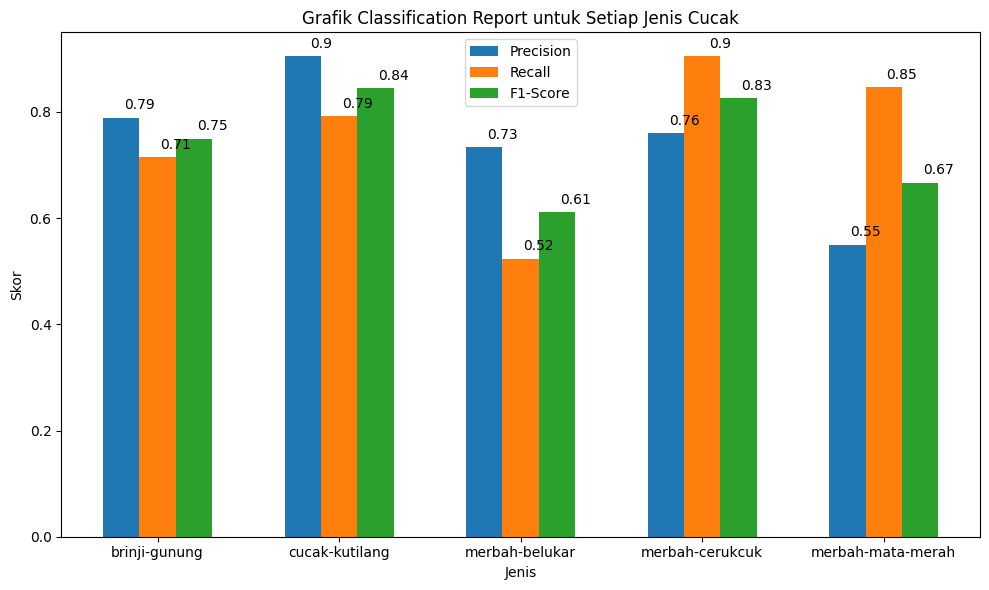

In [17]:
#Membuat grafik classification report
# Menghitung classification report
report = classification_report(y_test, y_pred, output_dict=True)

# Mengambil data dari report
classes = list(report.keys())[:-3]  # Mengabaikan 'accuracy', 'macro avg', 'weighted avg'
precision = [report[c]['precision'] for c in classes]
recall = [report[c]['recall'] for c in classes]
f1_score = [report[c]['f1-score'] for c in classes]

# Membuat grafik batang untuk setiap metrik
plt.figure(figsize=(10, 6))

width = 0.2  # Lebar batang

# Posisi batang untuk setiap metrik
x_precision = np.arange(len(classes))
x_recall = [x + width for x in x_precision]
x_f1_score = [x + width * 2 for x in x_precision]

# Plot batang
plt.bar(x_precision, precision, width, label='Precision')
plt.bar(x_recall, recall, width, label='Recall')
plt.bar(x_f1_score, f1_score, width, label='F1-Score')

# Label sumbu
plt.xlabel("Jenis")
plt.ylabel("Skor")
plt.title("Grafik Classification Report untuk Setiap Jenis Cucak")

# Menambahkan label kelas ke sumbu x
plt.xticks(x_precision + width, classes)

# Menampilkan legenda
plt.legend()

# Menambahkan angka pada batang (dengan teks horizontal)
for i, v in enumerate(precision):
    plt.text(x_precision[i] + width / 2, v + 0.01, str(round(v, 2)), ha='center', va='bottom')
for i, v in enumerate(recall):
    plt.text(x_recall[i] + width / 2, v + 0.01, str(round(v, 2)), ha='center', va='bottom')
for i, v in enumerate(f1_score):
    plt.text(x_f1_score[i] + width / 2, v + 0.01, str(round(v, 2)), ha='center', va='bottom')

plt.tight_layout()  # Menyesuaikan tata letak agar label tidak terpotong
plt.show()


Akurasi untuk setiap suara burung:
brinji-gunung: 0.7142857142857143
cucak-kutilang: 0.7916666666666666
merbah-mata-merah: 0.8461538461538461
merbah-cerukcuk: 0.9047619047619048
merbah-belukar: 0.5238095238095238


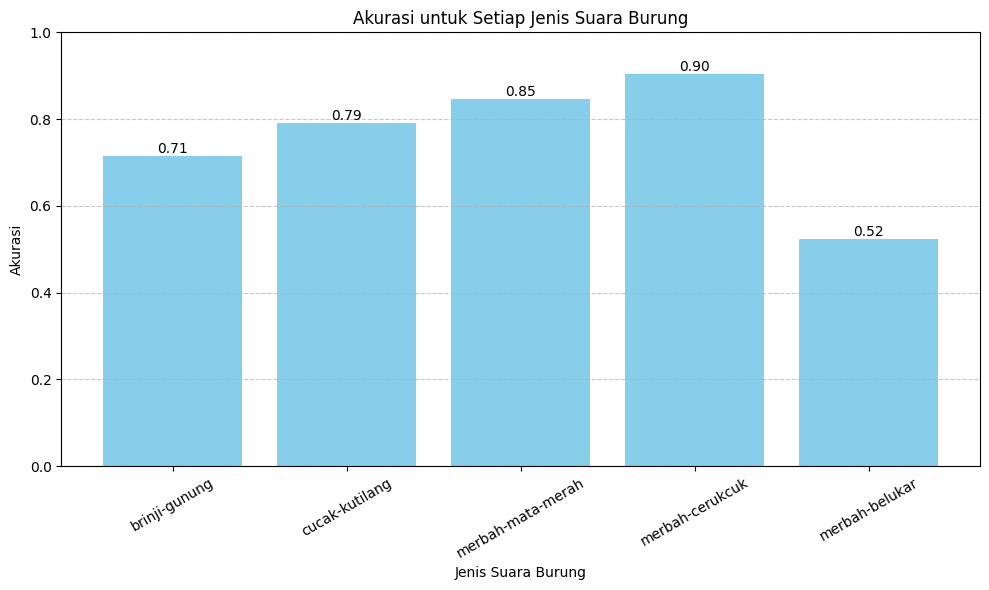

In [18]:
# Hitung akurasi untuk setiap jenis suara burung
accuracies = {}
for audio in audios:
    idx = np.where(np.array(y_test) == audio)[0]
    accuracy = np.mean(np.array(y_pred)[idx] == np.array(y_test)[idx])
    accuracies[audio] = accuracy

print("\nAkurasi untuk setiap suara burung:")
for audio, accuracy in accuracies.items():
    print(f"{audio}: {accuracy}")

# Ekstrak nama famili dan akurasi
families = list(accuracies.keys())
accuracies_values = list(accuracies.values())

# Plot grafik
plt.figure(figsize=(10, 6))
bars = plt.bar(families, accuracies_values, color='skyblue')
plt.xlabel('Jenis Suara Burung')
plt.ylabel('Akurasi')
plt.title('Akurasi untuk Setiap Jenis Suara Burung')
plt.ylim(0, 1)  # Menetapkan rentang sumbu y dari 0 hingga 1
plt.xticks(rotation=30)  # Putar label sumbu x agar lebih mudah dibaca
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Tambahkan grid pada sumbu y
plt.tight_layout()  # Atur layout agar tidak tumpang tindih

# Tambahkan label nilai akurasi di atas tiap batang bar
for bar, acc in zip(bars, accuracies_values):
    plt.text(bar.get_x() + bar.get_width() / 2, 
                bar.get_height(), 
                f'{acc:.2f}', 
                ha='center', 
                va='bottom')
plt.show()

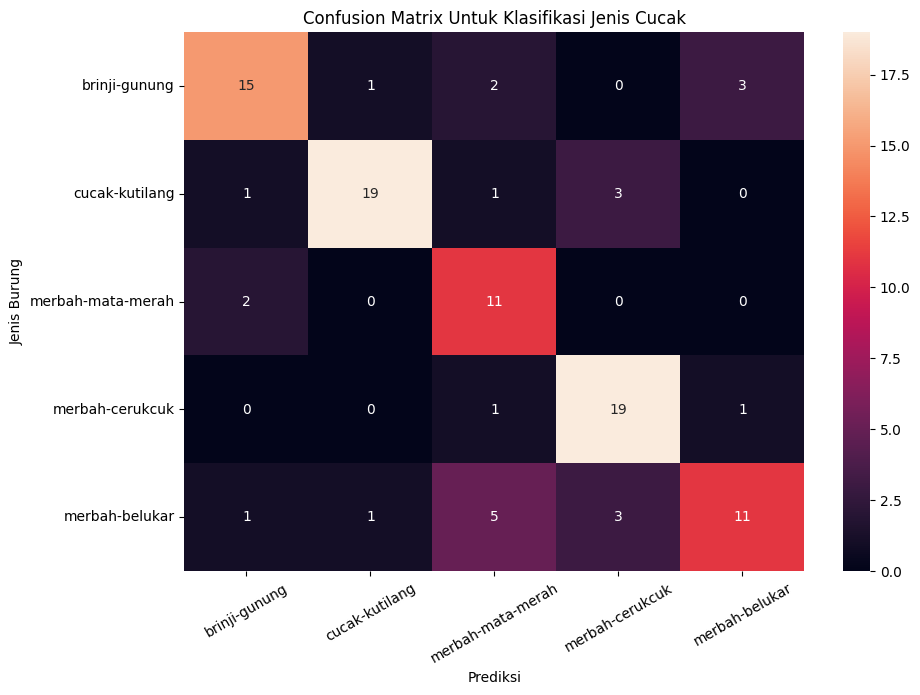

In [19]:
# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=audios)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=audios, yticklabels=audios)
plt.xlabel('Prediksi')
plt.xticks(rotation=30)
plt.ylabel('Jenis Burung')
plt.title('Confusion Matrix Untuk Klasifikasi Jenis Cucak')
plt.show()

In [20]:
# Mengambil nilai TP, TN, FP, FN untuk setiap jenis
# Hitung confusion matrix  
cm = confusion_matrix(y_test, y_pred, labels=audios)  

# Buat dictionary untuk menyimpan TP, TN, FP, FN  
results = {}  
for i, audio in enumerate(audios):  
    results[audio] = {}  
    results[audio]['TP'] = cm[i, i]  
    results[audio]['TN'] = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]  
    results[audio]['FP'] = np.sum(cm[:, i]) - cm[i, i]  
    results[audio]['FN'] = np.sum(cm[i, :]) - cm[i, i]  

# Tampilkan hasil TP, TN, FP, FN untuk setiap jenis burung  
print("Hasil TP, TN, FP, FN untuk setiap jenis burung:")  
for audio, values in results.items():  
    print(f"  {audio}:")  
    for metric, value in values.items():  
        print(f"    {metric}: {value}")

Hasil TP, TN, FP, FN untuk setiap jenis burung:
  brinji-gunung:
    TP: 15
    TN: 75
    FP: 4
    FN: 6
  cucak-kutilang:
    TP: 19
    TN: 74
    FP: 2
    FN: 5
  merbah-mata-merah:
    TP: 11
    TN: 78
    FP: 9
    FN: 2
  merbah-cerukcuk:
    TP: 19
    TN: 73
    FP: 6
    FN: 2
  merbah-belukar:
    TP: 11
    TN: 75
    FP: 4
    FN: 10


brinji-gunung
processing 100 audio in brinji-gunung file...
suara-cucak\brinji-gunung\XC141820 - Brinji gunung - Ixos virescens-1.wav


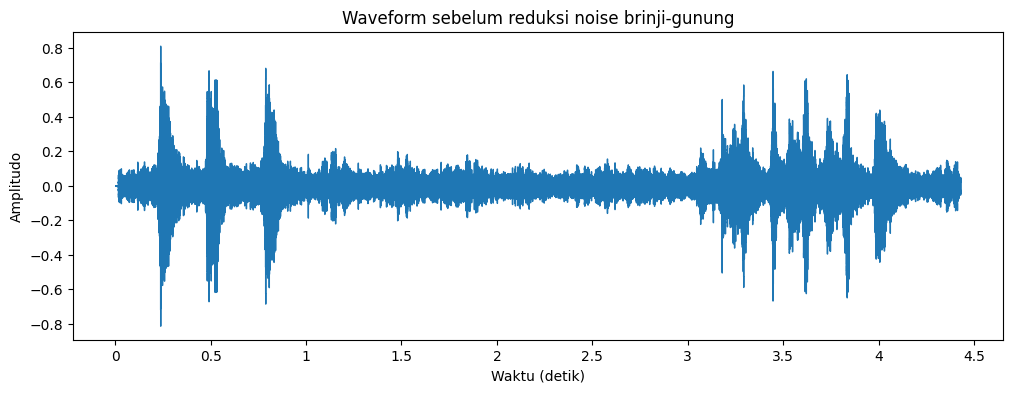

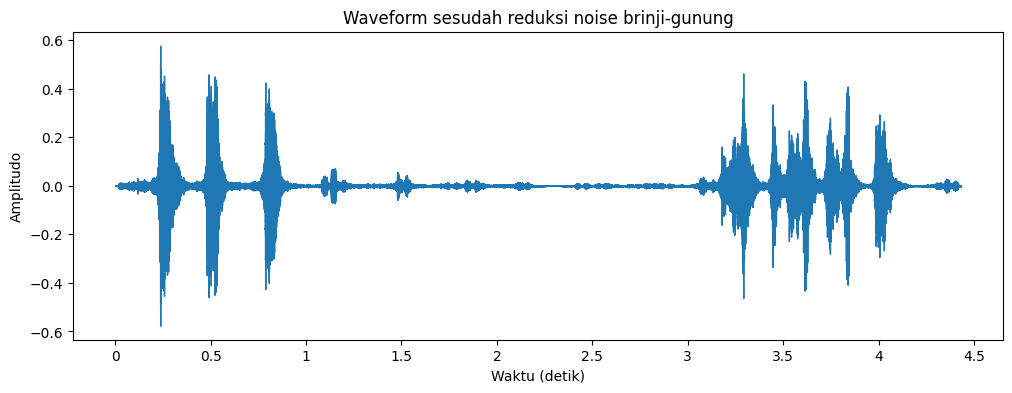

cucak-kutilang
processing 100 audio in cucak-kutilang file...
suara-cucak\cucak-kutilang\XC284505 - Sooty-headed Bulbul - Pycnonotus aurigaster aurigaster.wav


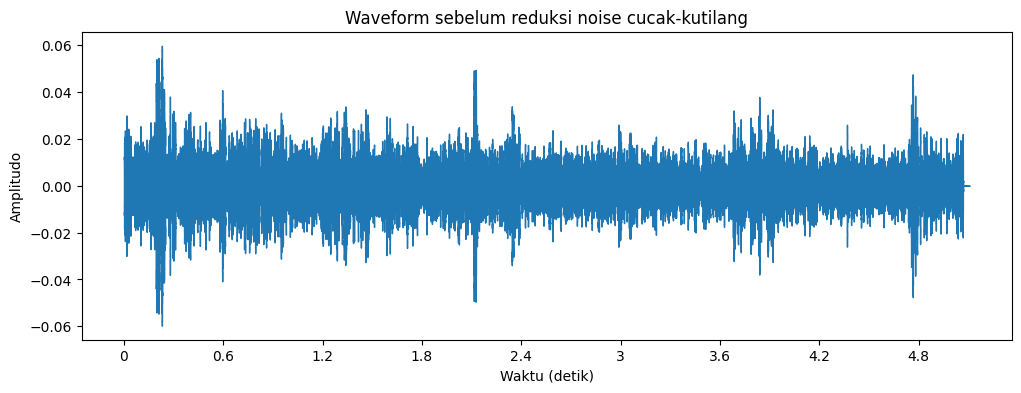

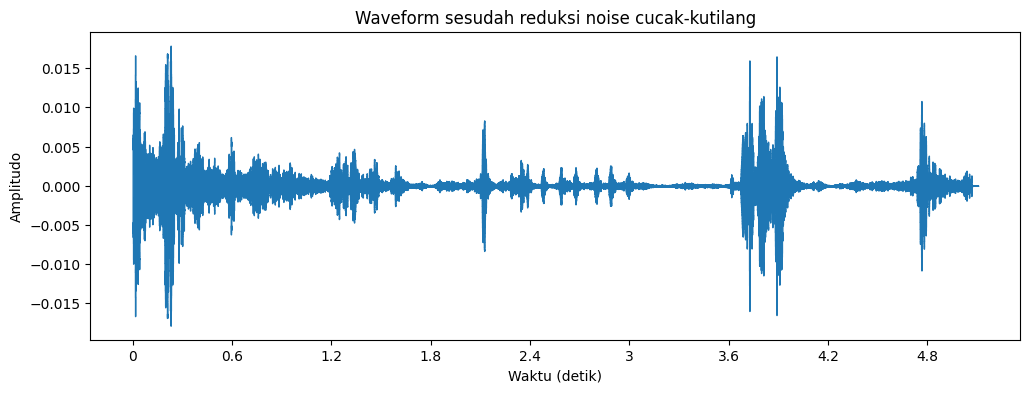

merbah-mata-merah
processing 100 audio in merbah-mata-merah file...
suara-cucak\merbah-mata-merah\XC151018 - Asian Red-eyed Bulbul - Pycnonotus brunneus-1.wav


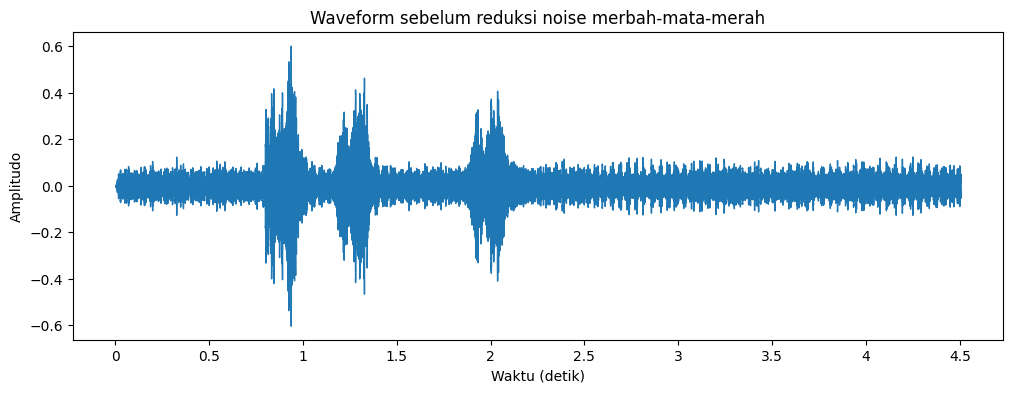

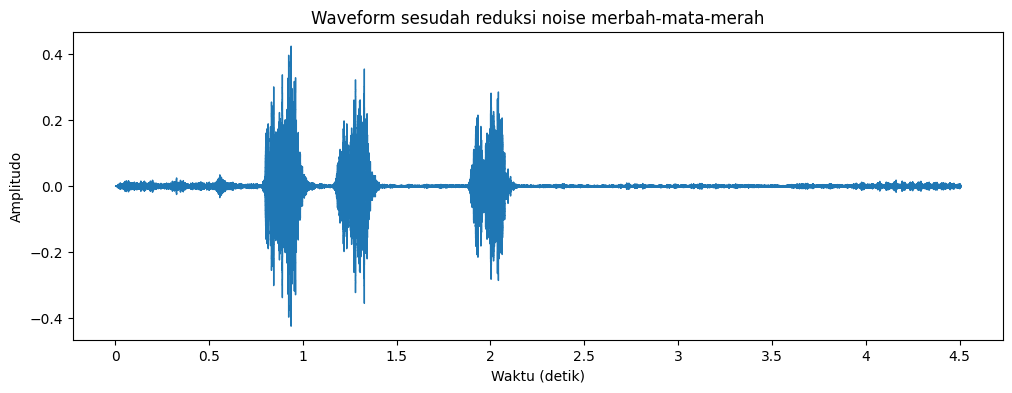

merbah-cerukcuk
processing 100 audio in merbah-cerukcuk file...
suara-cucak\merbah-cerukcuk\XC150003 - Yellow-vented Bulbul - Pycnonotus goiavier analis-1.wav


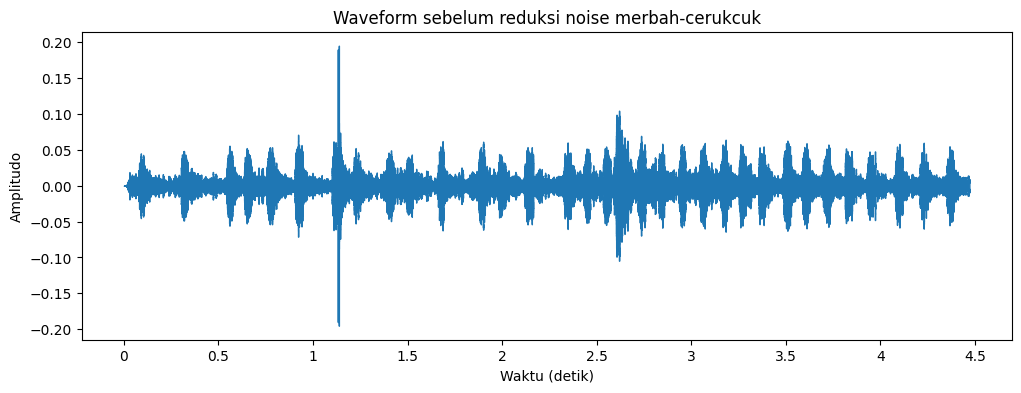

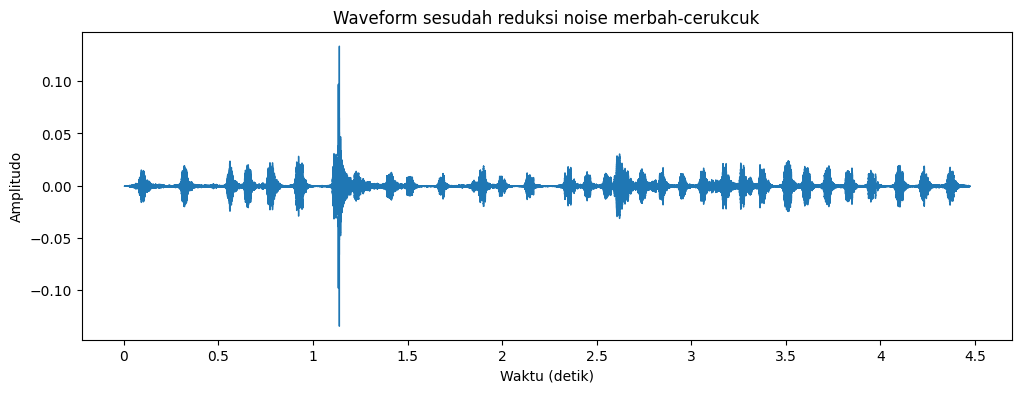

merbah-belukar
processing 100 audio in merbah-belukar file...
suara-cucak\merbah-belukar\XC431495 - Olive-winged Bulbul - Pycnonotus plumosus hutzi-1.wav


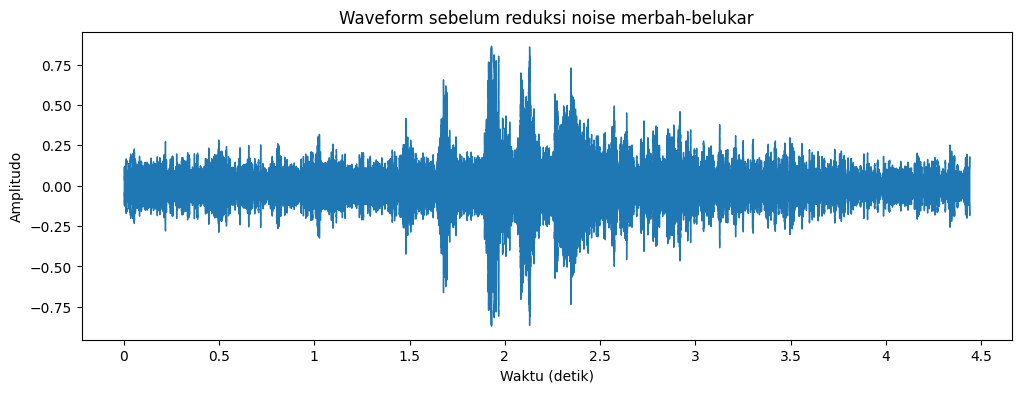

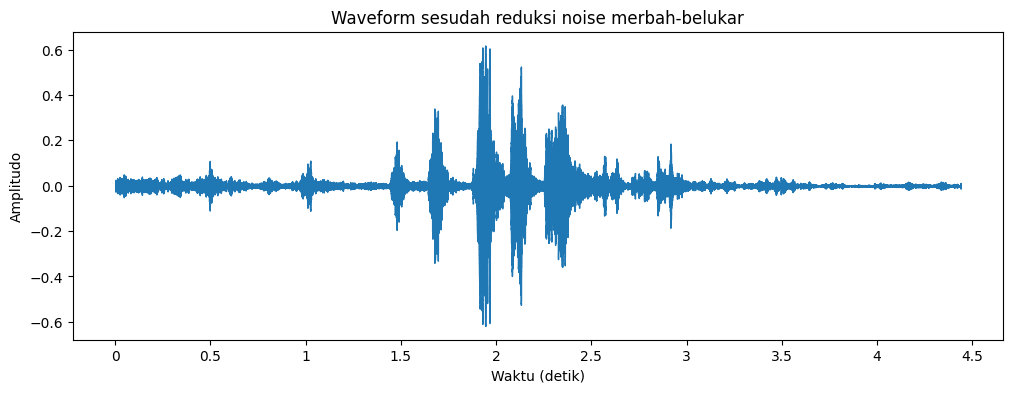

In [21]:
# Mengambil contoh data waveform untuk perbedaan sebelum dan sesudah reduksi noise
def extract_features(file_path, mfcc=True, n_mfcc=13):
    # Memeriksa ekstensi file
    if not file_path.endswith(".wav"):
        raise ValueError("File harus memiliki ekstensi .wav")

    # Membuka file audio
    try:
        with open(file_path, 'rb') as f:
            y, sr = librosa.load(f)
    except Exception as e:
        raise ValueError(f"Kesalahan saat membuka file: {e}")
    
    # Visualisasi sebelum reduksi noise
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Waveform sebelum reduksi noise {os.path.basename(os.path.dirname(file_path))}") # Menambahkan jenis suara ke judul
    plt.xlabel("Waktu (detik)")
    plt.ylabel("Amplitudo")
    plt.show()

    # Kurangi noise
    y = nr.reduce_noise(y=y, sr=sr)

    # Visualisasi setelah reduksi noise
    plt.figure(figsize=(12, 4))
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform setelah reduksi noise")
    plt.title(f"Waveform sesudah reduksi noise {os.path.basename(os.path.dirname(file_path))}") # Menambahkan jenis suara ke judul
    plt.xlabel("Waktu (detik)")
    plt.ylabel("Amplitudo")
    plt.show()

    # Ekstraksi MFCC
    if mfcc:
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        features = np.mean(mfccs, axis=1)
    else:
        features = None

    # Mengembalikan fitur MFCC, data audio, dan sample rate
    return features, y, sr

def generate_features(base_directory, audios):
    all_features = []
    all_labels = []
    all_waveforms = []
    all_sample_rates = []
    y = []

    for audio in audios:
        print(audio)
        audio_directory = os.path.join(base_directory, audio)
        sound_files = glob.glob(os.path.join(audio_directory, '*.wav'))
        print('processing %d audio in %s file...' % (len(sound_files), audio))
        for i, file in enumerate(sound_files):
            if i < 1: # Ambil jumlah file per audio
                print(file)
                feature, waveform, sample_rate = extract_features(file)
                if feature is not None:
                    all_features.append(feature)
                    all_labels.append(audio)
                    all_waveforms.append(waveform)
                    all_sample_rates.append(sample_rate)
    return all_features, all_labels, all_waveforms, all_sample_rates

# Path ke direktori data suara burung
base_directory = "suara-cucak"
audios = ['brinji-gunung', 'cucak-kutilang', 'merbah-mata-merah', 'merbah-cerukcuk', 'merbah-belukar']

# Generate fitur, label, gelombang suara, dan sample rate dari data suara burung
X, y, waveforms, sample_rates = generate_features(base_directory, audios)